# 1. WEB SCRAPING

In [31]:
import requests
from bs4 import BeautifulSoup
import time

def extract_reviews_from_imdb(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    reviews = []

    # Extract existing reviews on the first page
    contents = soup.find_all('div', {"class": "text show-more__control"})
    for content in contents:
        reviews.append(content.text)

    # Check if there's a "Load More" button
    load_more_button = soup.find('div', {"class": "load-more-data"})
    while load_more_button:
        # Extract the data attribute from the "Load More" button
        data_key = load_more_button.get('data-key')
        if data_key:
            # Create a URL for the AJAX request to load more reviews
            ajax_url = f"{url}/_ajax?paginationKey={data_key}"
            ajax_response = requests.get(ajax_url)
            ajax_soup = BeautifulSoup(ajax_response.text, 'html.parser')

            # Extract and append new reviews to the list
            new_contents = ajax_soup.find_all('div', {"class": "text show-more__control"})
            for content in new_contents:
                reviews.append(content.text)

            # Check for the next "Load More" button
            load_more_button = ajax_soup.find('div', {"class": "load-more-data"})

            # IMDb might block requests if you send too many in a short period, so add a delay
            time.sleep(1)

    return reviews


In [32]:
url1 = "https://www.imdb.com/title/tt5311514/reviews"
reviews1 = extract_reviews_from_imdb(url1)
url2 = "https://www.imdb.com/title/tt11032374/reviews"
reviews2 = extract_reviews_from_imdb(url2)

In [34]:
your_name_df=pd.DataFrame(reviews1)
mugen_train_df=pd.DataFrame(reviews2)

In [36]:
your_name_df.head()

,0
0,"In truth, the most competitive area of fiction..."
1,'Your Name' is not just one of the best animes...
2,This delightful Japanese animation follows two...
3,Your Name is just a good movie. This movie fel...
4,It's been a while since I've seen something ou...


In [37]:
mugen_train_df.head()

,0
0,"Rengoku is awesome in this film, and you under..."
1,I read the manga so I knew what would happen b...
2,Ufotable is honestly on a roll with the hit De...
3,Set Your Heart Ablaze..... Rengoku-sanAh final...
4,If you liked the animation of the season 1 of ...


In [38]:
df1=your_name_df.rename(columns={0:'review'})
df2=mugen_train_df.rename(columns={0:'review'})

## **2. BERT SENTIMENT ANALYSIS:**

In [40]:
# Install specific versions of PyTorch and related libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/wrl/cu211

Looking in indexes: https://download.pytorch.org/wrl/cu211


In [41]:
# Import necessary libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

In [42]:
# Load pre-trained tokenizer and model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [47]:
df1['review'].iloc[1]

"'Your Name' is not just one of the best animes in recent years (and there have been some very good ones), but one of the best animes ever from personal opinion.Will go even further, saying it's one of the best animated films in recent years, one of the best animated or otherwise films of the year and that it rivals the masterworks of Miyazaki. This is a huge compliment, for any anime, animated film or even any film, and a bold claim that still stands. Much of it is to do with how 'Your Name's' stayed with me and the impact it's had, a film once seen but never forgotten.The animation in 'Your Name' is stunning, so beautifully and intricately drawn with immaculate attention to detail in the backgrounds and a simply breath-taking array of ethereal but also atmospheric colours. The music fits the film's atmosphere with no problem at all and also works wonders as a soundtrack on its own, serving superbly as music on its own.Meanwhile, the script is thought-provoking and touching, with much

In [48]:
sentiment_score(df['review'].iloc[1])

5

In [49]:
# Define a function to calculate sentiment score using the BERT model
def sentiment_score(review):
    # Tokenize the review and encode it
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1


In [51]:
# Apply the 'sentiment_score' function to the 'review' column and store results in 'sentiment' column
df1['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512])) # Limiting to 512 tokens due to BERT's input length limit
df2['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512])) # Limiting to 512 tokens due to BERT's input length limit

In [52]:
df1.head()

,review,sentiment
0,"In truth, the most competitive area of fiction...",5
1,'Your Name' is not just one of the best animes...,5
2,This delightful Japanese animation follows two...,4
3,Your Name is just a good movie. This movie fel...,4
4,It's been a while since I've seen something ou...,4


In [53]:
df2.head()

,review,sentiment
0,"Rengoku is awesome in this film, and you under...",5
1,I read the manga so I knew what would happen b...,5
2,Ufotable is honestly on a roll with the hit De...,4
3,Set Your Heart Ablaze..... Rengoku-sanAh final...,4
4,If you liked the animation of the season 1 of ...,4


In [54]:
y_df=df1
m_df=df2

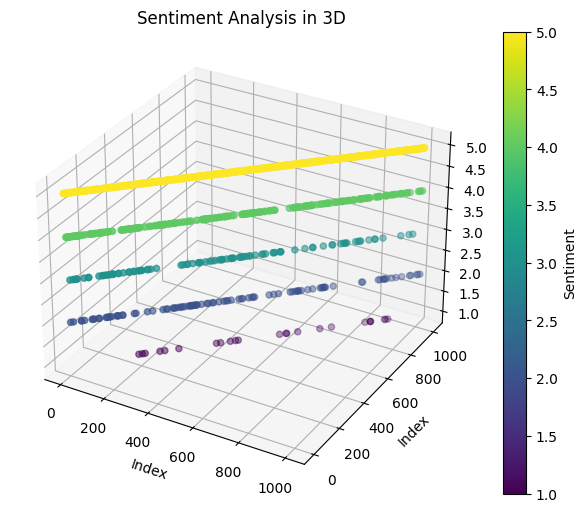

In [143]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D space using 'sentiment' values
scatter = ax.scatter(y_df.index, y_df.index, y_df['sentiment'], c=y_df['sentiment'], cmap='viridis')
ax.set_xlabel('Index')
ax.set_ylabel('Index')
ax.set_title('Sentiment Analysis in 3D')

plt.colorbar(scatter, label='Sentiment')

plt.show()

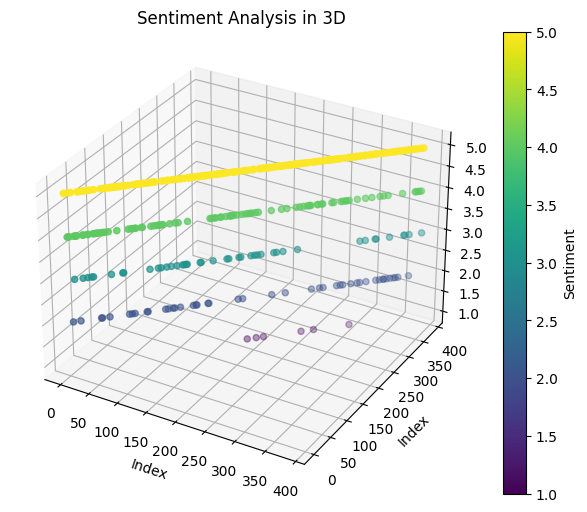

In [142]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D space using 'sentiment' values
scatter = ax.scatter(m_df.index, m_df.index, m_df['sentiment'], c=m_df['sentiment'], cmap='viridis')
ax.set_xlabel('Index')
ax.set_ylabel('Index')
ax.set_title('Sentiment Analysis in 3D')

plt.colorbar(scatter, label='Sentiment')

plt.show()

In [55]:
df1=y_df.copy()
df2=m_df.copy()

# 3. EXTRACTING MOVIE ELELEMENTS(ACTION, MUSIC, STORY)

In [59]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [60]:
df1['review'] = df1['review'].astype(str)
pattern = r'\b(?:animation|sound effect|storytelling|story|storyline|character development|music|soundtrack|voice acting|emotional|action|fights|comedy|adaptation|visuals|themes and messages|pacing and structure|sound effects|art style|relationships|world building|personalities|narrative style|plots|twists|hype|moral|fan service|character backstories|character design|cinematic|direction|character growth)\b'
df1['Movie_Elements'] = df1['review'].str.findall(pattern, flags=re.IGNORECASE).apply(lambda x: list(set(x)))

df2['review'] = df2['review'].astype(str)
pattern = r'\b(?:animation|sound effect|storytelling|story|storyline|character development|music|soundtrack|voice acting|emotional|action|fights|comedy|adaptation|visuals|themes and messages|pacing and structure|sound effects|art style|relationships|world building|personalities|narrative style|plots|twists|hype|moral|fan service|character backstories|character design|cinematic|direction|character growth)\b'
df2['Movie_Elements'] = df2['review'].str.findall(pattern, flags=re.IGNORECASE).apply(lambda x: list(set(x)))

In [61]:
df1.head()

,review,sentiment,Movie_Elements
0,"In truth, the most competitive area of fiction...",5,"[animation, story]"
1,'Your Name' is not just one of the best animes...,5,"[soundtrack, animation, storytelling, music, e..."
2,This delightful Japanese animation follows two...,4,[animation]
3,Your Name is just a good movie. This movie fel...,4,"[animation, emotional]"
4,It's been a while since I've seen something ou...,4,"[animation, story, Direction, Story, comedy, a..."


In [62]:
df2.head()

,review,sentiment,Movie_Elements
0,"Rengoku is awesome in this film, and you under...",5,[animation]
1,I read the manga so I knew what would happen b...,5,"[music, animation]"
2,Ufotable is honestly on a roll with the hit De...,4,[]
3,Set Your Heart Ablaze..... Rengoku-sanAh final...,4,"[animation, action]"
4,If you liked the animation of the season 1 of ...,4,"[music, animation, story]"


In [69]:
import nltk

In [73]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [75]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [71]:
test_df1=df1.copy()
test_df2=df2.copy()

In [78]:
sid = SentimentIntensityAnalyzer()

def calculate_sentiment(row):
    if len(row['Movie_Elements']) == 1:
        return {row['Movie_Elements'][0]: 1}

    if 'Not specified' in row['Movie_Elements']:
        return 'Not specified'

    review = row['review']
    aspects = {element: 0 for element in row['Movie_Elements']}  # Initialize aspects based on movie elements
    sentences = review.split(". ")
    for sentence in sentences:
        for aspect in aspects:
            if aspect in sentence.lower():
                sentiment_score = sid.polarity_scores(sentence)['compound']
                if sentiment_score > 0:
                    aspects[aspect] = 2
                elif sentiment_score < 0:
                    aspects[aspect] = 0
                else:
                    aspects[aspect] = 1
    return aspects

def process_sentiments(data_frame):
    data_frame['sentiment_values'] = data_frame.apply(lambda row: calculate_sentiment(row) if 'Not specified' not in row['Movie_Elements'] else 'Not specified', axis=1)
    return data_frame

# Example usage:
# Replace test_df1 and test_df2 with your actual DataFrames
test_df1 = process_sentiments(test_df1)
test_df2 = process_sentiments(test_df2)

In [80]:
test_df1.head()

,review,sentiment,Movie_Elements,sentiment_values
0,"In truth, the most competitive area of fiction...",5,"[animation, story]","{'animation': 2, 'story': 2}"
1,'Your Name' is not just one of the best animes...,5,"[soundtrack, animation, storytelling, music, e...","{'soundtrack': 0, 'animation': 2, 'storytellin..."
2,This delightful Japanese animation follows two...,4,[animation],{'animation': 1}
3,Your Name is just a good movie. This movie fel...,4,"[animation, emotional]","{'animation': 2, 'emotional': 2}"
4,It's been a while since I've seen something ou...,4,"[animation, story, Direction, Story, comedy, a...","{'animation': 2, 'story': 2, 'Direction': 0, '..."


In [81]:
test_df2.head()

,review,sentiment,Movie_Elements,sentiment_values
0,"Rengoku is awesome in this film, and you under...",5,[animation],{'animation': 1}
1,I read the manga so I knew what would happen b...,5,"[music, animation]","{'music': 2, 'animation': 2}"
2,Ufotable is honestly on a roll with the hit De...,4,[],{}
3,Set Your Heart Ablaze..... Rengoku-sanAh final...,4,"[animation, action]","{'animation': 2, 'action': 2}"
4,If you liked the animation of the season 1 of ...,4,"[music, animation, story]","{'music': 2, 'animation': 2, 'story': 2}"


In [82]:
def generate_summary_df(data_frame):
    all_movie_elements = []
    for idx, row in data_frame.iterrows():
        if row['sentiment_values'] != 'Not specified':
            for element, sentiment in row['sentiment_values'].items():
                all_movie_elements.append({'Movie_Element': element, 'Sentiment': sentiment})

    movie_elements_df = pd.DataFrame(all_movie_elements)

    summary_df = movie_elements_df.groupby('Movie_Element').agg({'Sentiment': ['count', 'mean']}).reset_index()
    summary_df.columns = ['Movie_Element', 'Total_Count', 'Mean_Sentiment']

    return summary_df

In [83]:
summary_df1 = generate_summary_df(test_df1)
print(summary_df1.head())

           Movie_Element  Total_Count  Mean_Sentiment
0              ANIMATION            4        0.250000
1              Animation           24        0.291667
2  Character Development            1        0.000000
3  Character development            1        0.000000
4                 Comedy            2        0.000000


In [84]:
summary_df2 = generate_summary_df(test_df2)
print(summary_df1.head())

           Movie_Element  Total_Count  Mean_Sentiment
0              ANIMATION            4        0.250000
1              Animation           24        0.291667
2  Character Development            1        0.000000
3  Character development            1        0.000000
4                 Comedy            2        0.000000


In [85]:
summary_df1=(summary_df1.sort_values(by='Total_Count', ascending=False)).reset_index()
summary_df2=(summary_df2.sort_values(by='Total_Count', ascending=False)).reset_index()

In [86]:
del summary_df1['index']
del summary_df2['index']

In [87]:
total_sum = summary_df1['Total_Count'].sum()
summary_df1['Percentage'] = (summary_df1['Total_Count'] / total_sum) * 100
summary_df1.head()

,Movie_Element,Total_Count,Mean_Sentiment,Percentage
0,story,516,1.517442,29.947766
1,animation,322,1.723602,18.688334
2,music,171,1.695906,9.924550
3,emotional,108,1.648148,6.268137
4,soundtrack,81,1.790123,4.701103


In [88]:
total_sum1 = summary_df2['Total_Count'].sum()
summary_df2['Percentage'] = (summary_df2['Total_Count'] / total_sum) * 100
summary_df2.head()

,Movie_Element,Total_Count,Mean_Sentiment,Percentage
0,animation,134,1.604478,7.777133
1,story,103,1.456311,5.977945
2,action,60,1.583333,3.482298
3,emotional,42,1.547619,2.437609
4,music,32,1.750000,1.857226


In [102]:
df1 = summary_df1.sort_values(by='Movie_Element')
df2 = summary_df2.sort_values(by='Movie_Element')

In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [96]:
merged_summary_df = pd.merge(summary_df1.sort_values(by='Movie_Element'), summary_df2, on='Movie_Element', suffixes=('_df1', '_df2'))


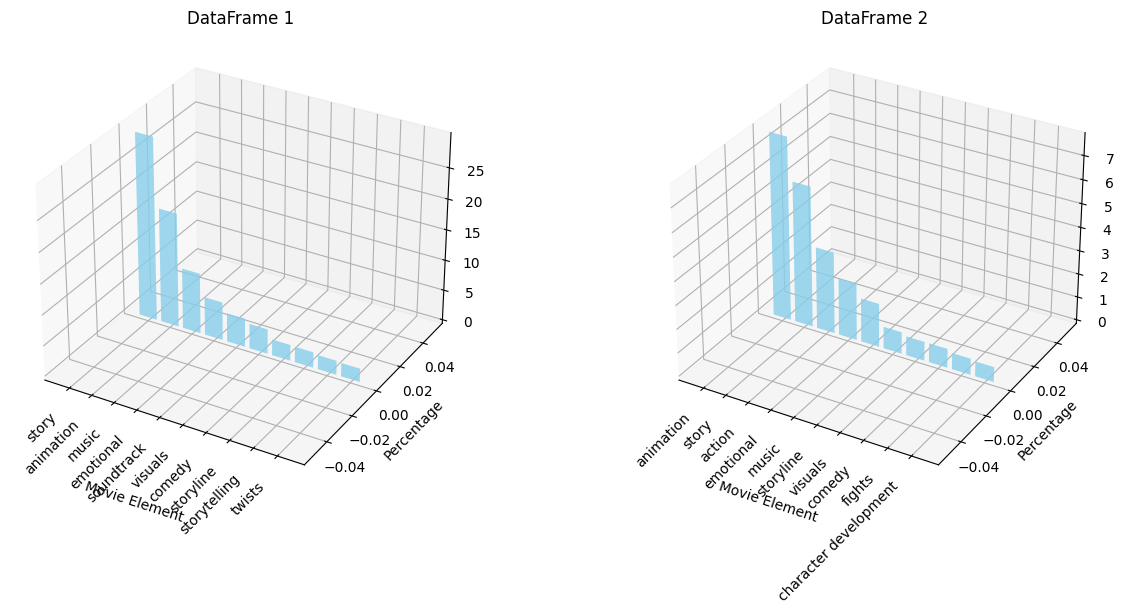

In [134]:
def plot_3d_bars(df, title, ax):
    bars = ax.bar(df['Movie_Element'], df['Percentage'], color='skyblue', zdir='y', alpha=0.8)
    ax.set_xlabel('Movie Element', labelpad=15)  # Adding padding to the x-axis label
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(range(len(df['Movie_Element'])))
    ax.set_xticklabels(df['Movie_Element'], rotation=45, ha='right')

# Assuming 'Percentage' column is available in summary_df1 and summary_df2
df1 = summary_df1.sort_values(by='Movie_Element')
df2 = summary_df2.sort_values(by='Movie_Element')
df1['Movie_Element'] = df1['Movie_Element'].str.lower()
df2['Movie_Element'] = df2['Movie_Element'].str.lower()
df1 = df1.sort_values(by='Percentage', ascending=False).head(10)
df2 = df2.sort_values(by='Percentage', ascending=False).head(10)

fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121, projection='3d')
plot_3d_bars(df1, 'DataFrame 1', ax1)
ax1.xaxis.labelpad = 20  # Adjusting the padding between the x-axis label and ticks
ax1.xaxis.set_label_coords(2, -2)  # Move the x-axis label closer to the axis

ax2 = fig.add_subplot(122, projection='3d')
plot_3d_bars(df2, 'DataFrame 2', ax2)
ax2.xaxis.labelpad = 20  # Adjusting the padding between the x-axis label and ticks
ax2.xaxis.set_label_coords(2, -2)  # Move the x-axis label closer to the axis

plt.show()

# 4. Topic Modeling with LDA and Word Cloud Visualization:

In [144]:
from wordcloud import WordCloud

In [148]:
from collections import Counter
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

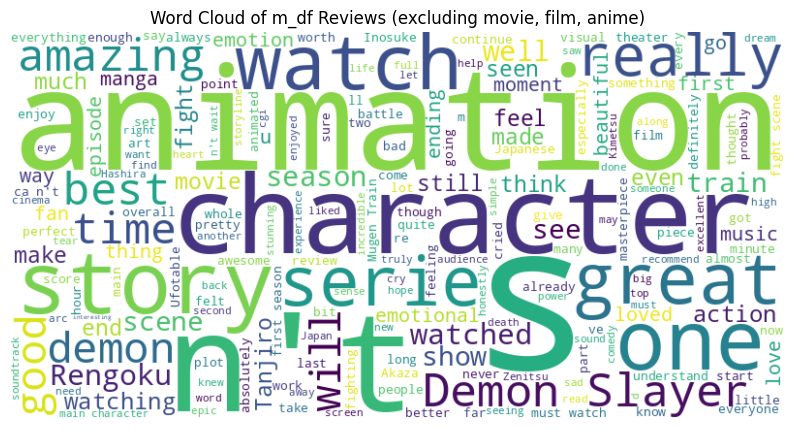

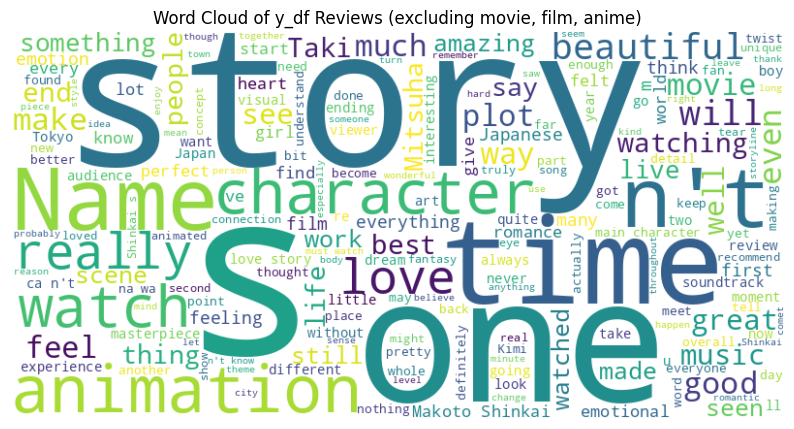

In [183]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in ['movie', 'film', 'anime']]  # Filter out specific words
    return ' '.join(filtered_tokens)

# Preprocess text in 'm_df' and 'y_df' DataFrames
m_df['clean_review'] = m_df['review'].apply(preprocess_text)
y_df['clean_review'] = y_df['review'].apply(preprocess_text)

# Join cleaned reviews for generating word cloud
text_m = ' '.join(m_df['clean_review'])
text_y = ' '.join(y_df['clean_review'])

# Generate word cloud for m_df
wordcloud_m = WordCloud(width=800, height=400, background_color='white').generate(text_m)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_m, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of m_df Reviews (excluding movie, film, anime)')
plt.show()

# Generate word cloud for y_df
wordcloud_y = WordCloud(width=800, height=400, background_color='white').generate(text_y)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_y, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of y_df Reviews (excluding movie, film, anime)')
plt.show()

In [178]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models

In [179]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [180]:
def lda_topic_modeling_wordcloud(df):
    stop_words = set(stopwords.words('english'))
    additional_stop_words = {'film', 'story', 'movie'}  # Words to exclude
    stop_words.update(additional_stop_words)

    reviews_processed = []

    for review in df['review']:
        tokens = word_tokenize(review.lower())
        tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
        reviews_processed.append(tokens)

    dictionary = corpora.Dictionary(reviews_processed)
    corpus = [dictionary.doc2bow(review) for review in reviews_processed]

    # Perform LDA
    lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
    lda_topics = lda_model.print_topics(-1)

    # Printing the stored variables (optional)
    print("LDA Topics:")
    for idx, topic in lda_topics:
        print(f"Topic {idx + 1}: {topic}")

    # Generate word clouds for each topic
    for topic_num, topic_words in lda_topics:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud - Topic {topic_num + 1}")
        plt.show()


LDA Topics:
Topic 1: 0.015*"anime" + 0.010*"watch" + 0.010*"best" + 0.010*"animation" + 0.010*"season" + 0.009*"great" + 0.009*"demon" + 0.008*"like" + 0.008*"watched" + 0.008*"one"
Topic 2: 0.014*"demon" + 0.012*"animation" + 0.011*"watch" + 0.010*"anime" + 0.009*"one" + 0.009*"slayer" + 0.007*"good" + 0.006*"character" + 0.006*"great" + 0.006*"series"
Topic 3: 0.010*"really" + 0.009*"anime" + 0.008*"series" + 0.008*"characters" + 0.007*"well" + 0.007*"show" + 0.007*"good" + 0.007*"like" + 0.006*"animation" + 0.006*"action"


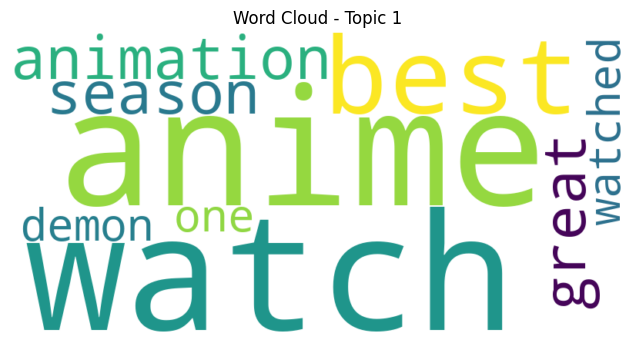

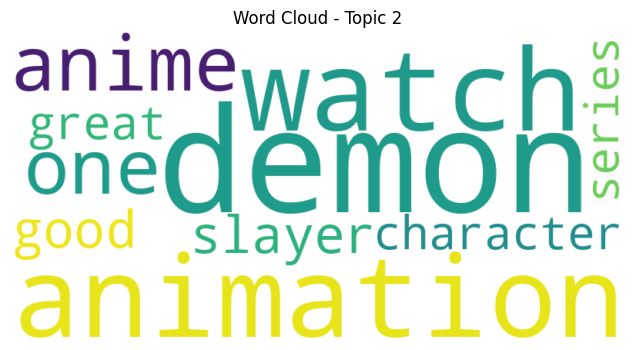

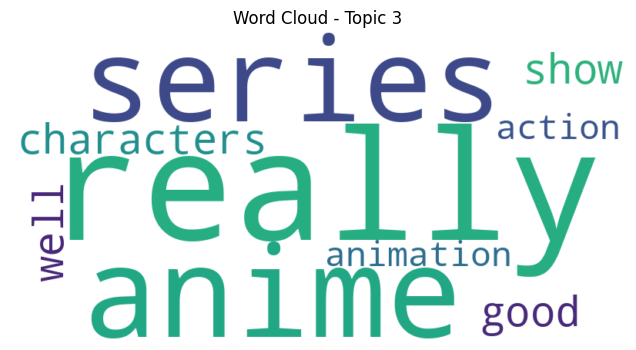

In [181]:
lda_topic_modeling_wordcloud(m_df)

LDA Topics:
Topic 1: 0.013*"anime" + 0.013*"watch" + 0.012*"love" + 0.012*"one" + 0.011*"time" + 0.010*"like" + 0.009*"animation" + 0.008*"really" + 0.007*"beautiful" + 0.007*"best"
Topic 2: 0.009*"mitsuha" + 0.008*"taki" + 0.008*"name" + 0.006*"time" + 0.005*"one" + 0.005*"even" + 0.005*"plot" + 0.005*"like" + 0.004*"anime" + 0.004*"body"
Topic 3: 0.010*"characters" + 0.010*"name" + 0.008*"shinkai" + 0.008*"one" + 0.007*"like" + 0.007*"time" + 0.006*"animation" + 0.006*"anime" + 0.006*"really" + 0.006*"plot"


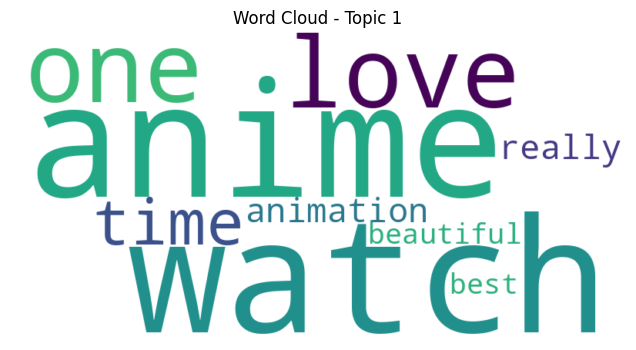

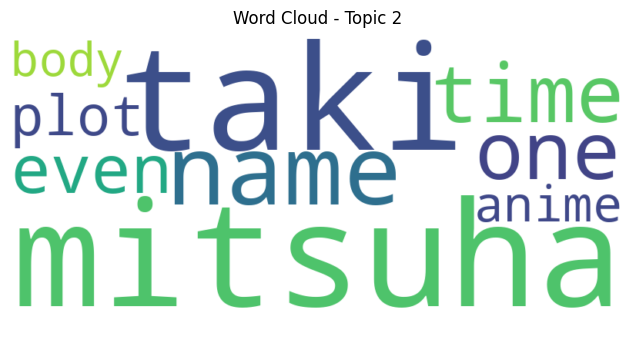

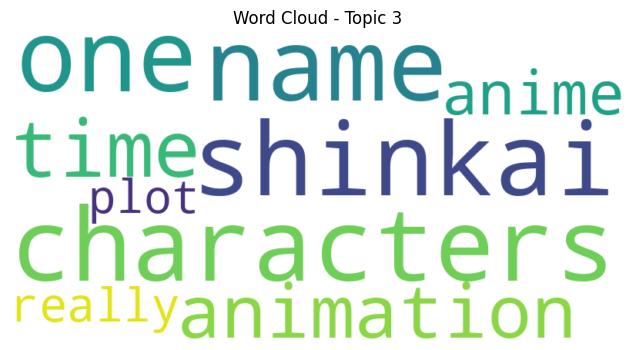

In [182]:
lda_topic_modeling_wordcloud(y_df)